In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle

In [2]:
import matplotlib as mpl
from cycler import cycler

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 1.4

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.width'] = 0.4
mpl.rcParams['xtick.minor.width'] = 0.4
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.major.width'] = 0.4
mpl.rcParams['ytick.minor.width'] = 0.4
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10


mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 9

mpl.rcParams['figure.figsize'] = 6, 4

mpl.rcParams['axes.prop_cycle'] = cycler("color", ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff7f0e']

# Plotting
fig_dir = "../figs"

def create_lineplot_histogram(distribution, bins=20):
    vals, bin_edges = np.histogram(distribution, bins=bins)

    xvals = np.repeat(bin_edges, 2)
    yvals = np.repeat(vals, 2)
    yvals = np.concatenate(([0], yvals, [0]))

    return xvals, yvals

In [3]:
model_name = 'gemma-2-2b-it'

In [4]:
import re

def get_layer_and_thres(string):
    pattern = r'_layer(\d+)_sparsity_thres(\d+(?:\.\d+)?)'
    match = re.search(pattern, string)
    if match:
        return int(match.group(1)), float(match.group(2))
    return None

In [5]:
data_dir = '../data/unlearn_results/gemma-2-2b-it/sae/'
sae_files = os.listdir(data_dir)

sae_df = []
for file in sae_files:
    if 'dangerous' not in file:
        continue
    with open(os.path.join(data_dir, file), 'rb') as f:
        metrics = pickle.load(f)
        # metrics_list.append(metrics)
        
    # get pattern _layer{layer}_sparsity_thres{thres}
    layer, thres = get_layer_and_thres(file)
    
    row = {}
    
    n_se_questions = 0
    n_se_correct_questions = 0
    
    for dataset in metrics:
        if dataset == 'loss_added':
            row[dataset] = metrics[dataset]
        elif dataset == 'ablate_params':
            for k in metrics[dataset]:
                row[k] = metrics[dataset][k]
        else:
            row[dataset] = metrics[dataset]['mean_correct']
            
            if dataset not in ['college_biology', 'wmdp-bio']:
                n_se_correct_questions += metrics[dataset]['total_correct']
                n_se_questions += len(metrics[dataset]['is_correct'])
                # print(n_se_correct_questions, n_se_questions)
                # print(dataset)
    
    row['layer'] = layer
    row['sparsity_thres'] = thres
    row['n_features'] = len(row['features_to_ablate'])
    row['all_side_effects_mcq'] = n_se_correct_questions / n_se_questions
    sae_df.append(row)
        
sae_df = pd.DataFrame(sae_df)
sae_df

,loss_added,wmdp-bio,high_school_us_history,college_computer_science,high_school_geography,human_aging,college_biology,intervention_method,features_to_ablate,multiplier,layer,sparsity_thres,n_features,all_side_effects_mcq
0,-0.000025,1.000000,1.0,1.0,1.0,1.0,1.0,clamp_feature_activation,[27504],1,11,0.01,1,1.0
1,-0.000038,1.000000,1.0,1.0,1.0,1.0,1.0,clamp_feature_activation,[27504],5,11,0.01,1,1.0
2,-0.000052,1.000000,1.0,1.0,1.0,1.0,1.0,clamp_feature_activation,[27504],10,11,0.01,1,1.0
3,-0.000086,0.998084,1.0,1.0,1.0,1.0,1.0,clamp_feature_activation,[27504],50,11,0.01,1,1.0
4,0.000106,0.990421,1.0,1.0,1.0,1.0,1.0,clamp_feature_activation,[27504],100,11,0.01,1,1.0


In [6]:
rmu_df = []
data_dir = '../data/unlearn_results/gemma-2-2b-it/rmu/correct/'
rmu_files = os.listdir(data_dir)


def get_rmu_hyper_param(string):
    pattern = r's(\d+)_a(\d+)_layer(\d+).pkl'
    match = re.search(pattern, string)
    if match:
        return int(match.group(1)), int(match.group(2)), int(match.group(3))
    return None

for file in rmu_files:
    with open(os.path.join(data_dir, file), 'rb') as f:
        metrics = pickle.load(f)
        
    
    s, a, layer = get_rmu_hyper_param(file)
    row = {}

    n_se_questions = 0
    n_se_correct_questions = 0

    for dataset in metrics:
        if dataset == 'loss_added':
            row[dataset] = metrics[dataset].item()
        elif dataset == 'loss_return':
            continue
        elif dataset == 'ablate_params':
            for k in metrics[dataset]:
                row[k] = metrics[dataset][k]
        else:
            row[dataset] = metrics[dataset]['mean_correct']
            
            if dataset not in ['college_biology', 'wmdp-bio']:
                n_se_correct_questions += metrics[dataset]['total_correct']
                n_se_questions += len(metrics[dataset]['is_correct'])
            
    row['layer'] = layer
    row['s'] = s
    row['a'] = a
    row['all_side_effects_mcq'] = n_se_correct_questions / n_se_questions
    
    # print(n_se_questions)

    rmu_df.append(row)
    
rmu_df = pd.DataFrame(rmu_df)
rmu_df
        
    

,wmdp-bio,high_school_us_history,high_school_geography,college_computer_science,human_aging,college_biology,loss_added,layer,s,a,all_side_effects_mcq
0,0.954023,1.000000,1.000000,1.0,1.000000,1.000000,-0.010138,11,100,100,1.000000
1,0.645594,1.000000,1.000000,1.0,1.000000,0.986301,0.012161,3,100,100,1.000000
2,0.860153,1.000000,1.000000,1.0,0.987654,1.000000,0.000050,7,100,100,0.996667
3,0.984674,1.000000,1.000000,1.0,1.000000,1.000000,-0.008853,11,100,300,1.000000
4,0.852490,1.000000,1.000000,1.0,1.000000,0.986301,0.002477,3,100,300,1.000000
5,0.965517,1.000000,1.000000,1.0,0.987654,1.000000,-0.001342,7,100,300,0.996667
6,0.998084,1.000000,1.000000,1.0,1.000000,1.000000,-0.008455,11,100,500,1.000000
7,0.986590,1.000000,1.000000,1.0,1.000000,1.000000,0.001225,3,100,500,1.000000
8,0.990421,1.000000,1.000000,1.0,0.987654,1.000000,-0.001542,7,100,500,0.996667
9,0.955939,1.000000,1.000000,1.0,1.000000,1.000000,-0.006477,11,200,100,1.000000


In [7]:
rmu_files

['gemma_2_2b_it_s100_a100_layer11.pkl',
 'gemma_2_2b_it_s100_a100_layer3.pkl',
 'gemma_2_2b_it_s100_a100_layer7.pkl',
 'gemma_2_2b_it_s100_a300_layer11.pkl',
 'gemma_2_2b_it_s100_a300_layer3.pkl',
 'gemma_2_2b_it_s100_a300_layer7.pkl',
 'gemma_2_2b_it_s100_a500_layer11.pkl',
 'gemma_2_2b_it_s100_a500_layer3.pkl',
 'gemma_2_2b_it_s100_a500_layer7.pkl',
 'gemma_2_2b_it_s200_a100_layer11.pkl',
 'gemma_2_2b_it_s200_a100_layer3.pkl',
 'gemma_2_2b_it_s200_a100_layer7.pkl',
 'gemma_2_2b_it_s200_a300_layer11.pkl',
 'gemma_2_2b_it_s200_a300_layer3.pkl',
 'gemma_2_2b_it_s200_a300_layer7.pkl',
 'gemma_2_2b_it_s200_a500_layer11.pkl',
 'gemma_2_2b_it_s200_a500_layer3.pkl',
 'gemma_2_2b_it_s200_a500_layer7.pkl',
 'gemma_2_2b_it_s400_a100_layer3.pkl',
 'gemma_2_2b_it_s400_a100_layer7.pkl',
 'gemma_2_2b_it_s400_a300_layer3.pkl',
 'gemma_2_2b_it_s400_a300_layer7.pkl',
 'gemma_2_2b_it_s400_a500_layer3.pkl',
 'gemma_2_2b_it_s400_a500_layer7.pkl']

In [8]:
df

NameError: name 'df' is not defined

In [10]:
rmu_df

,wmdp-bio,high_school_us_history,high_school_geography,college_computer_science,human_aging,college_biology,loss_added,layer,s,a,all_side_effects_mcq
0,0.954023,1.000000,1.000000,1.0,1.000000,1.000000,-0.010138,11,100,100,1.000000
1,0.645594,1.000000,1.000000,1.0,1.000000,0.986301,0.012161,3,100,100,1.000000
2,0.860153,1.000000,1.000000,1.0,0.987654,1.000000,0.000050,7,100,100,0.996667
3,0.984674,1.000000,1.000000,1.0,1.000000,1.000000,-0.008853,11,100,300,1.000000
4,0.852490,1.000000,1.000000,1.0,1.000000,0.986301,0.002477,3,100,300,1.000000
5,0.965517,1.000000,1.000000,1.0,0.987654,1.000000,-0.001342,7,100,300,0.996667
6,0.998084,1.000000,1.000000,1.0,1.000000,1.000000,-0.008455,11,100,500,1.000000
7,0.986590,1.000000,1.000000,1.0,1.000000,1.000000,0.001225,3,100,500,1.000000
8,0.990421,1.000000,1.000000,1.0,0.987654,1.000000,-0.001542,7,100,500,0.996667
9,0.955939,1.000000,1.000000,1.0,1.000000,1.000000,-0.006477,11,200,100,1.000000


/root/unlearning/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


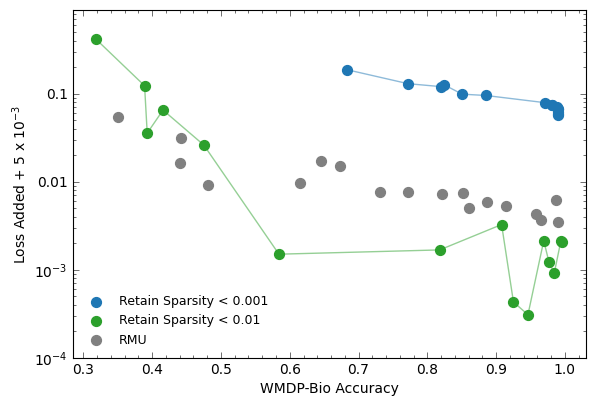

In [17]:
def plot_metrics(df, x_col, y_col, color_col, fig_name, rmu_df=None):
    fig, ax = plt.subplots(figsize=(6, 4))

    if y_col == 'loss_added':
        # y_min = df[y_col].min()
        # offset = abs(y_min) + 1e-4 if y_min <= 0 else 0
        # print(offset)
        offset = 5e-3
        
    # Get unique values
    unique_values = df[color_col].unique()

    # Create a scatter plot and line for each unique value
    for i, value in enumerate(unique_values):
        subset = df[df[color_col] == value].sort_values(by=x_col)
        color = colors[i % len(colors)]
        
        if y_col == 'loss_added':
            y_values = np.log10(subset[y_col] + offset)
        else:
            y_values = subset[y_col]
        # Plot line
        ax.plot(subset[x_col], y_values, color=color, alpha=0.5)
        
        # Plot scatter points
        ax.scatter(subset[x_col], y_values, 
                    c=[color], label=f'Retain Sparsity < {value}', s=50)
    
    # Plot RMU results
    if rmu_df is not None:
        y_values = np.log10(rmu_df[y_col] + offset)
        ax.scatter(rmu_df[x_col], y_values, c='grey', label='RMU', s=50)

    yticks = [-4, -3, -2, -1]
    yticklabels = [r"10$^{-4}$", r"10$^{-3}$", 0.01, 0.1]
    yminor_ticks = np.log10(np.concatenate((np.arange(1e-4, 1e-3, 1e-4),
                                            np.arange(1e-3, 1e-2, 1e-3),
                                            np.arange(1e-2, 1e-1, 1e-2),
                                            np.arange(1e-1, 1, 1e-1))))

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_yticks(yminor_ticks, minor=True)


    ax.legend(loc='lower left')

    ax.set_xlabel('WMDP-Bio Accuracy')
    ax.set_ylabel(f'Loss Added + 5 x 10$^{{-3}}$')
    

    fig.subplots_adjust(right=0.98, top=0.98)
    fig.savefig(fig_dir + f"/multiple_features/{model_name}_{fig_name}.png", dpi=400)
    # plt.show()


df = sae_df.query('layer == 3').query('sparsity_thres == 0.01')
plot_metrics(
    df, 
    x_col='wmdp-bio', 
    y_col='loss_added', 
    color_col='sparsity_thres', 
    fig_name='wmdp-bio_vs_loss_added',
    rmu_df=rmu_df
)


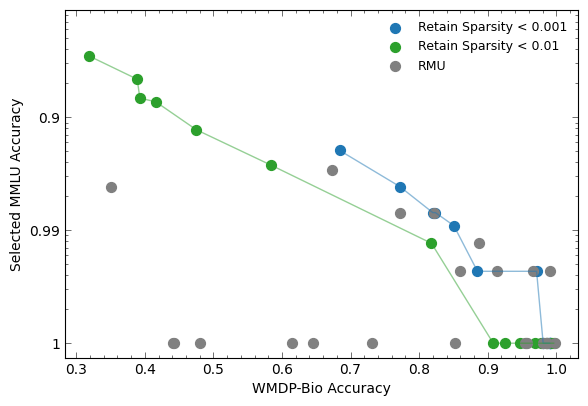

In [18]:
def plot_metrics(df, x_col, y_col, color_col, fig_name, rmu_df=None):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Get unique values
    unique_values = df[color_col].unique()
    
    eps = 1e-3
    # Create a scatter plot and line for each unique value
    for i, value in enumerate(unique_values):
        subset = df[df[color_col] == value].sort_values(by=x_col)
        color = colors[i % len(colors)]
        
        y_value = np.log10(1 - subset[y_col] + eps)
        # Plot line
        ax.plot(subset[x_col], y_value, color=color, alpha=0.5)
        
        # Plot scatter points
        ax.scatter(subset[x_col], y_value, 
                    c=[color], label=f'Retain Sparsity < {value}', s=50)
    
    # Plot RMU results
    if rmu_df is not None:
        y_value = np.log10(1 - rmu_df[y_col] + eps)
        ax.scatter(rmu_df[x_col], y_value, c='grey', label='RMU', s=50)


    yticks = [-3, -2, -1]
    yticklabels = [1, 0.99, 0.9]
    yminor_ticks = np.log10(np.concatenate((np.arange(1e-3, 1e-2, 1e-3),
                                            np.arange(1e-2, 1e-1, 1e-2),
                                            np.arange(1e-1, 1, 1e-1))))

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_yticks(yminor_ticks, minor=True)
    
    ax.legend()

    ax.set_xlabel('WMDP-Bio Accuracy')
    ax.set_ylabel(f'Selected MMLU Accuracy')
    # ax.invert_yaxis()

    fig.subplots_adjust(right=0.98, top=0.98)
    fig.savefig(fig_dir + f"/multiple_features/{model_name}_{fig_name}.png", dpi=400)
    # plt.show()


df = sae_df.query('layer == 3')
plot_metrics(
    df, 
    x_col='wmdp-bio', 
    y_col='all_side_effects_mcq', 
    color_col='sparsity_thres', 
    fig_name='wmdp-bio_vs_all_side_effects_mcq',
    rmu_df=rmu_df
)


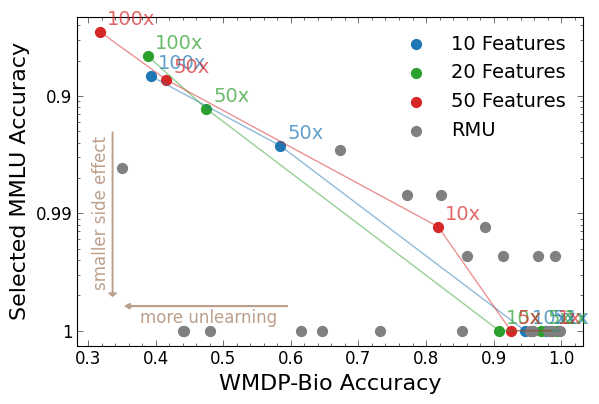

In [87]:
def plot_metrics(df, x_col, y_col, color_col, fig_name, rmu_df=None):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Get unique values
    unique_values = df[color_col].unique()
    
    eps = 1e-3
    # Create a scatter plot and line for each unique value
    for i, value in enumerate(unique_values):
        subset = df[df[color_col] == value].sort_values(by=x_col)
        color = colors[i % len(colors)]
        
        y_value = np.log10(1 - subset[y_col] + eps)
        # Plot line
        ax.plot(subset[x_col], y_value, color=color, alpha=0.5)
        
        # Plot scatter points
        ax.scatter(subset[x_col], y_value, 
                    c=[color], label=f'{value} Features', s=50)

        # Add multiplier labels
        for x, y, mult in zip(subset[x_col], y_value, subset['multiplier']):
            ax.annotate(f"{mult}x", (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=14, 
                        alpha=0.7, color=color)
            
    # Plot RMU results
    if rmu_df is not None:
        y_value = np.log10(1 - rmu_df[y_col] + eps)
        ax.scatter(rmu_df[x_col], y_value, c='grey', label='RMU', s=50)


    yticks = [-3, -2, -1]
    yticklabels = [1, 0.99, 0.9]
    yminor_ticks = np.log10(np.concatenate((np.arange(1e-3, 1e-2, 1e-3),
                                            np.arange(1e-2, 1e-1, 1e-2),
                                            np.arange(1e-1, 1, 1e-1))))

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_yticks(yminor_ticks, minor=True)
    
    ax.legend(fontsize=14)

    ax.set_xlabel('WMDP-Bio Accuracy', fontsize=16)
    ax.set_ylabel(f'Selected MMLU Accuracy', fontsize=16)
    # ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    
    # Add arrows and labels using ax.arrow
    # Arrow pointing left
    # dark_orange = '#CD5C08'
    dark_orange = 'gray'
    dark_orange = '#BC9F8B'
    # ax.arrow(0.515, 0.17, -0.32, 0,  # Start at (0.35, 0.2) and draw an arrow 0.07 units to the left
    #         head_width=0.015, head_length=0.01, fc=dark_orange, ec=dark_orange, lw=1.2, 
    #         length_includes_head=True, transform=ax.transAxes)
    # ax.text(0.36, 0.12, 'more unlearning', fontsize=12, color=dark_orange, ha='center', transform=ax.transAxes)

    # # Arrow pointing down
    # ax.arrow(0.17, 0.70, 0, -0.5,  # Start at (0.35, 0.2) and draw an arrow 0.08 units downward
    #         head_width=0.015, head_length=0.01, fc=dark_orange, ec=dark_orange, lw=1, 
    #         length_includes_head=True, transform=ax.transAxes)
    # ax.text(0.13, 0.23, 'smaller side effect', fontsize=12, color=dark_orange, ha='left', transform=ax.transAxes, rotation=90)
    ax.arrow(0.415, 0.12, -0.32, 0,  # Start at (0.35, 0.2) and draw an arrow 0.07 units to the left
            head_width=0.015, head_length=0.01, fc=dark_orange, ec=dark_orange, lw=1.2, 
            length_includes_head=True, transform=ax.transAxes)
    ax.text(0.26, 0.07, 'more unlearning', fontsize=12, color=dark_orange, ha='center', transform=ax.transAxes)

    # Arrow pointing down
    ax.arrow(0.07, 0.65, 0, -0.5,  # Start at (0.35, 0.2) and draw an arrow 0.08 units downward
            head_width=0.015, head_length=0.01, fc=dark_orange, ec=dark_orange, lw=1, 
            length_includes_head=True, transform=ax.transAxes)
    ax.text(0.03, 0.18, 'smaller side effect', fontsize=12, color=dark_orange, ha='left', transform=ax.transAxes, rotation=90)

    plt.tight_layout()
    fig.subplots_adjust(right=0.98, top=0.98)
    fig.savefig(fig_dir + f"/multiple_features/{model_name}_{fig_name}.pdf", dpi=400)
    # plt.show()


df = sae_df.query('layer == 3').query('sparsity_thres == 0.01')
plot_metrics(
    df, 
    x_col='wmdp-bio', 
    y_col='all_side_effects_mcq', 
    color_col='n_features', 
    fig_name='wmdp-bio_vs_all_side_effects_mcq_color_by_n_features',
    rmu_df=rmu_df
)


/root/unlearning/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


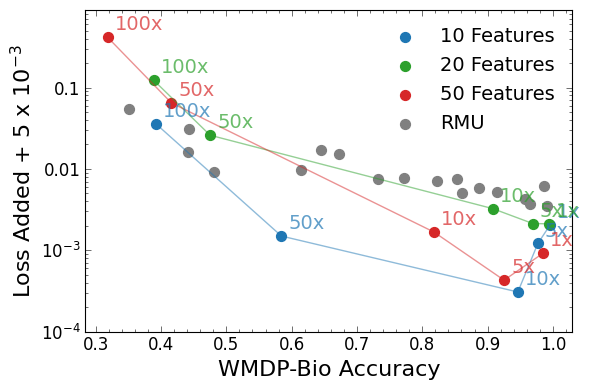

In [88]:
def plot_metrics(df, x_col, y_col, color_col, fig_name, rmu_df=None):
    fig, ax = plt.subplots(figsize=(6, 4))

    if y_col == 'loss_added':
        # y_min = df[y_col].min()
        # offset = abs(y_min) + 1e-4 if y_min <= 0 else 0
        # print(offset)
        offset = 5e-3
        
    # Get unique values
    unique_values = df[color_col].unique()

    # Create a scatter plot and line for each unique value
    for i, value in enumerate(unique_values):
        subset = df[df[color_col] == value].sort_values(by=x_col)
        color = colors[i % len(colors)]
        
        if y_col == 'loss_added':
            y_values = np.log10(subset[y_col] + offset)
        else:
            y_values = subset[y_col]
        # Plot line
        ax.plot(subset[x_col], y_values, color=color, alpha=0.5)
        
        # Plot scatter points
        ax.scatter(subset[x_col], y_values, 
                    c=[color], label=f'{value} Features', s=50)
    
        # Add multiplier labels
        for x, y, mult in zip(subset[x_col], y_values, subset['multiplier']):
            ax.annotate(f"{mult}x", (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=14, 
                        alpha=0.7, color=color)
            
    # Plot RMU results
    if rmu_df is not None:
        y_values = np.log10(rmu_df[y_col] + offset)
        ax.scatter(rmu_df[x_col], y_values, c='grey', label='RMU', s=50)

    yticks = [-4, -3, -2, -1]
    yticklabels = [r"10$^{-4}$", r"10$^{-3}$", 0.01, 0.1]
    yminor_ticks = np.log10(np.concatenate((np.arange(1e-4, 1e-3, 1e-4),
                                            np.arange(1e-3, 1e-2, 1e-3),
                                            np.arange(1e-2, 1e-1, 1e-2),
                                            np.arange(1e-1, 1, 1e-1))))

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_yticks(yminor_ticks, minor=True)


    ax.legend(loc='upper right', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    


    ax.set_xlabel('WMDP-Bio Accuracy', fontsize=16)
    ax.set_ylabel(f'Loss Added + 5 x 10$^{{-3}}$', fontsize=16)
    

    fig.subplots_adjust(right=0.98, top=0.98)
    plt.tight_layout()
    fig.savefig(fig_dir + f"/multiple_features/{model_name}_{fig_name}.pdf", dpi=400)
    # plt.show()

df = sae_df.query('layer == 3').query('sparsity_thres == 0.01')
plot_metrics(
    df, 
    x_col='wmdp-bio', 
    y_col='loss_added', 
    color_col='n_features', 
    fig_name='wmdp-bio_vs_loss_added_color_by_n_features',
    rmu_df=rmu_df
)


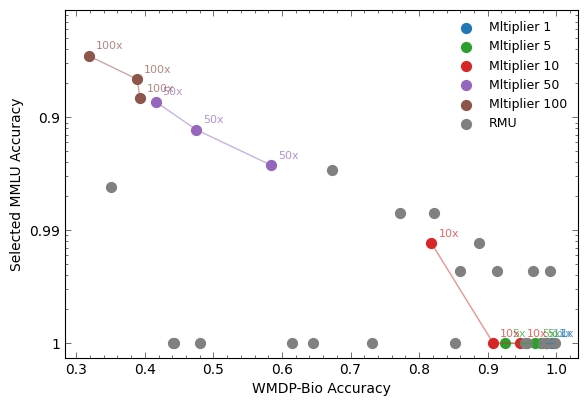

In [23]:
def plot_metrics(df, x_col, y_col, color_col, fig_name, rmu_df=None):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Get unique values
    unique_values = df[color_col].unique()
    
    eps = 1e-3
    # Create a scatter plot and line for each unique value
    for i, value in enumerate(unique_values):
        subset = df[df[color_col] == value].sort_values(by=x_col)
        color = colors[i % len(colors)]
        
        y_values = np.log10(1 - subset[y_col] + eps)
        # Plot line
        ax.plot(subset[x_col], y_values, color=color, alpha=0.5)
        
        # Plot scatter points
        ax.scatter(subset[x_col], y_values, 
                    c=[color], label=f'Mltiplier {value}', s=50)
    
        # Add multiplier labels
        for x, y, mult in zip(subset[x_col], y_values, subset['multiplier']):
            ax.annotate(f"{mult}x", (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8, 
                        alpha=0.7, color=color)
            
    # Plot RMU results
    if rmu_df is not None:
        y_values = np.log10(1 - rmu_df[y_col] + eps)
        ax.scatter(rmu_df[x_col], y_values, c='grey', label='RMU', s=50)


    yticks = [-3, -2, -1]
    yticklabels = [1, 0.99, 0.9]
    yminor_ticks = np.log10(np.concatenate((np.arange(1e-3, 1e-2, 1e-3),
                                            np.arange(1e-2, 1e-1, 1e-2),
                                            np.arange(1e-1, 1, 1e-1))))

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_yticks(yminor_ticks, minor=True)
    
    ax.legend()

    ax.set_xlabel('WMDP-Bio Accuracy')
    ax.set_ylabel(f'Selected MMLU Accuracy')
    # ax.invert_yaxis()

    fig.subplots_adjust(right=0.98, top=0.98)
    fig.savefig(fig_dir + f"/multiple_features/{model_name}_{fig_name}.png", dpi=400)
    # plt.show()


df = sae_df[sae_df['sparsity_thres'] == 0.01]
df = df.sort_values(by='multiplier')

plot_metrics(
    df, 
    x_col='wmdp-bio', 
    y_col='all_side_effects_mcq', 
    color_col='multiplier', 
    fig_name='wmdp-bio_vs_all_side_effects_mcq_color_by_multiplier',
    rmu_df=rmu_df
)


8     100
10    100
12    100
13     10
14     10
16     10
17      1
18      1
20      1
21     50
23     50
25     50
26      5
27      5
29      5
Name: multiplier, dtype: int64

In [18]:
from unlearning.metrics import create_df_from_metrics

create_df_from_metrics(metrics_list)

,loss_added,wmdp-bio,high_school_us_history,college_computer_science,high_school_geography,human_aging,college_biology,wmdp-bio_prob,high_school_us_history_prob,college_computer_science_prob,high_school_geography_prob,human_aging_prob,college_biology_prob
0,0.175387,0.683908,0.933962,1.0,0.961538,0.950617,0.835616,0.014290,0.154663,0.000603,0.060577,0.133301,0.035889
1,0.052656,0.990421,1.000000,1.0,1.000000,1.000000,1.000000,0.819336,0.905273,0.907227,0.890137,0.873535,0.917480
2,0.061436,0.990421,1.000000,1.0,1.000000,1.000000,1.000000,0.815918,0.905273,0.906250,0.889648,0.872559,0.916504
3,0.068749,0.980843,1.000000,1.0,1.000000,1.000000,1.000000,0.811035,0.904785,0.904297,0.889160,0.871582,0.915527
4,0.090124,0.885057,1.000000,1.0,1.000000,0.987654,1.000000,0.764160,0.901855,0.891113,0.886230,0.860352,0.903809
5,0.114890,0.819923,0.990566,1.0,0.990385,0.975309,0.958904,0.714355,0.896484,0.830566,0.881348,0.863770,0.880859
6,0.053128,0.990421,1.000000,1.0,1.000000,1.000000,1.000000,0.817383,0.905273,0.908691,0.890137,0.872559,0.916504
7,0.062039,0.990421,1.000000,1.0,1.000000,1.000000,1.000000,0.812012,0.905273,0.908691,0.889648,0.871094,0.914551


In [ ]:
def create_df_from_metrics(metrics_list):

    df_data = []

    dataset_names = list(metrics_list[0].keys())
    
    if 'loss_added' in dataset_names:
        dataset_names.remove('loss_added')

    if 'ablate_params' in dataset_names:
        dataset_names.remove('ablate_params')

    for metric in metrics_list:
        if 'loss_added' in metric:
            loss_added = metric['loss_added']
        else:
            loss_added = np.NaN
        mean_correct = [metric[dataset_name]['mean_correct'] for dataset_name in dataset_names]
        mean_predicted_probs = [metric[dataset_name]['mean_predicted_probs'] for dataset_name in dataset_names]

        metric_data = np.concatenate(([loss_added], mean_correct, mean_predicted_probs))
        
        df_data.append(metric_data)

    df_data = np.array(df_data)

    columns = ['loss_added'] + dataset_names + [x + '_prob' for x in dataset_names]    
    df = pd.DataFrame(df_data, columns=columns)

    return df
